<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/impostors_krikri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Krikri

In [1]:
%%capture
!pip install torch transformers accelerate

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Set the model ID and the device
model_id = "ilsp/Llama-Krikri-8B-Instruct"
device = "cuda" # or "cpu" if you have a powerful CPU and limited VRAM

try:
    # Loading the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Load the model
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        dtype=torch.bfloat16, # Using bfloat16 for efficiency on supported GPUs
        device_map="auto"     # Automatically distributing the model across available devices
    )
    model.to(device)

    # Prepare your instruction/prompt
    prompt = "Ποια είναι η πρωτεύουσα της Ελλάδας;" # "What is the capital of Greece?"

    # Apply the chat template for the Instruct model
    messages = [
        {"role": "user", "content": prompt}
    ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    # Generate the response
    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and print the result
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(response)

except OSError as e:
    print(f"Error loading the model or tokenizer: {e}")
    print("This might be due to network issues or problems accessing the model files on Hugging Face.")
    print("Please try running the cell again later.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

user

Ποια είναι η πρωτεύουσα της Ελλάδας;assistant

Η πρωτεύουσα της Ελλάδας είναι η Αθήνα.


In [3]:
def prompt_krikri(model, prompt, system_prompt, temperature=0.3):
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt},
  ]

  input_ids = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(device)

  outputs = model.generate(
      input_ids,
      max_new_tokens=16,
      do_sample=True,
      temperature=temperature,
      pad_token_id=tokenizer.eos_token_id
  )
  #response = tokenizer.decode(outputs[0], skip_special_tokens=True)
  # In Classification Decoding Mode
  full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

  assistant_prefix = "<|start_header_id|>assistant<|end_header_id|>"
  response = full_response.split(assistant_prefix)[-1].strip()

  # Finally, remove the end-of-turn token if it appears
  response = response.replace("<|eot_id|>", "").strip()

  return response

# Gutenberg

In [4]:
%%capture
!git clone https://github.com/greek-nlp/gen-a.git
!git clone https://github.com/greek-nlp/benchmark.git
!pip install zenodo-get
!pip install datasets
!pip install conll-df

import pandas as pd
import importlib

gr_data = pd.read_csv('gen-a/data.csv')
gena = importlib.import_module("gen-a.data_wrapper")

In [5]:
barzokas = gena.BarzokasDt(datasets=gr_data).get('train')
barzokas.drop_duplicates(inplace=True, subset=['text'])
barzokas = barzokas[barzokas.status=='parsable']
barzokas = barzokas[barzokas.tokensCount>1000]

Download github items in directory: /content/repo_56
Successfully downloaded data/corpora


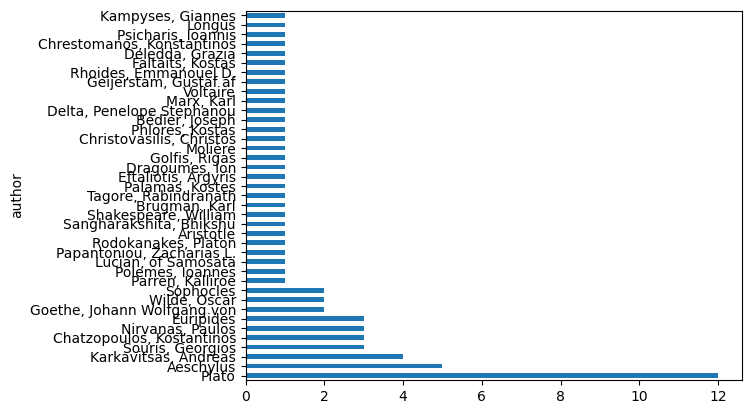

In [12]:
gutenberg = barzokas[barzokas.publisher=='project_gutenberg']
gutenberg.author.value_counts().plot.barh();

In [15]:
import random

def get_random_middle_excerpt(text, length=1000, offset_range=10000):
  """
  Returns an excerpt by choosing a random start point within
  a certain range around the absolute middle of the text.
  """
  text_length = len(text)

  # 1. Find the ideal middle start (if we were taking the fixed middle)
  middle_start_ideal = text_length // 2 - length // 2

  # 2. Define the range for the random starting point
  # The starting point will be between:
  #   max(0, middle_start_ideal - offset_range)
  # and
  #   min(text_length - length, middle_start_ideal + offset_range)

  # Ensure the start index is not negative and the excerpt fits in the text
  min_start = max(0, middle_start_ideal - offset_range // 2)
  max_start = min(text_length - length, middle_start_ideal + offset_range // 2)

  # Handle cases where the text is too short
  if min_start >= max_start:
      return text[:length] # Just return the first part or the whole text if shorter

  # 3. Pick a random starting index
  start_index = random.randint(min_start, max_start)

  # 4. Extract the excerpt
  return text[start_index : start_index + length]

In [16]:
gutenberg_authors = ['Karkavitsas, Andreas', 'Souris, Georgios', 'Chatzopoulos, Kostantinos', 'Nirvanas, Paulos', 'Polemes, Ioannes', 'Papantoniou, Zacharias L.', 'Eftaliotis, Argyris', 'Dragoumes, Ion', 'Golfis, Rigas', 'Delta, Penelope Stephanou', 'Christovasilis, Christos']
gutenberg_dataset = gutenberg[gutenberg.author.isin(gutenberg_authors)]
for i in range(1, 11):
  gutenberg_dataset[f'excerpt_{i}'] = gutenberg_dataset.text.apply(get_random_middle_excerpt)

/tmp/ipython-input-3479885394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gutenberg_dataset[f'excerpt_{i}'] = gutenberg_dataset.text.apply(get_random_middle_excerpt)
/tmp/ipython-input-3479885394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gutenberg_dataset[f'excerpt_{i}'] = gutenberg_dataset.text.apply(get_random_middle_excerpt)
/tmp/ipython-input-3479885394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [26]:
instruct = "Given an excerpt from a Greek book, predict its author or return 'None' (and nothing else) if you don't know. Select the author's name from the following list: " + ', '.join(gutenberg_authors)
prompt_krikri(model, gutenberg_dataset.excerpt_1.values[0], instruct)

'None'

In [27]:
from tqdm.notebook import tqdm
instruct = "Given an excerpt from a Greek book, predict its author or return 'None' (and nothing else) if you don't know. Select the author's name from the following list: " + ', '.join(gutenberg_authors)
for i in tqdm(range(1, 11)):
  gutenberg_dataset[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(gutenberg_dataset[f'excerpt_{i}'].values)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-794978924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gutenberg_dataset[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(gutenberg_dataset[f'excerpt_{i}'].values)]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
gutenberg_dataset

,id,title,author,type,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,authorYearOfDeath,...,krikri_1,krikri_2,krikri_3,krikri_4,krikri_5,krikri_6,krikri_7,krikri_8,krikri_9,krikri_10
4,PG34132,Όταν σπάση τα δεσμά του: Δράμα σε μέρη τρία,"Nirvanas, Paulos",NaN,NaN,NaN,NaN,NaN,1866.0,1937.0,...,None,None,None,None,None\n\nThe text provided does not contain suf...,None,None,None,None,None
7,PG32741,Ποιήματα - Τόμος Πέμπτος - Φασουλής Φιλόσοφος,"Souris, Georgios",NaN,NaN,NaN,NaN,NaN,1853.0,1919.0,...,None,None,None,None,None,None,None,None,The excerpt provided contains references to Gr...,None
9,PG35114,Πεζοί Ρυθμοί,"Papantoniou, Zacharias L.",NaN,NaN,NaN,NaN,NaN,1877.0,1940.0,...,None,None,None,None,None,None,None,None,None,None
13,PG39224,Ειρηνικά,"Polemes, Ioannes",NaN,NaN,NaN,NaN,NaN,1862.0,1924.0,...,None,None,None,None,None,The excerpt provided contains elements of lyri...,None,The excerpt provided contains poetic language ...,None,None
15,PG31445,Διηγήματα του Γυλιού,"Karkavitsas, Andreas",NaN,NaN,NaN,NaN,NaN,1866.0,1922.0,...,None,None,None,None,None,None,None,None,None,None
27,PG31631,Ο αρχαιολόγος,"Karkavitsas, Andreas",NaN,NaN,NaN,NaN,NaN,1866.0,1922.0,...,None,None,None,None,None,The text provided contains elements of Greek l...,The text provided contains elements of Greek l...,None,None,The excerpt provided contains elements of the ...
31,PG31403,Απλοί Τρόποι,"Chatzopoulos, Kostantinos",NaN,NaN,NaN,NaN,NaN,1868.0,1920.0,...,None,None,None,None,None,None,None,None,None,None
34,PG32215,"Ιστορία της Ρωμιοσύνης, Πρώτος τόμος","Eftaliotis, Argyris",NaN,NaN,NaN,NaN,NaN,1849.0,1923.0,...,None,None,None,None,None\n\nThe excerpt provided contains historic...,None,None,The excerpt provided contains elements typical...,None,None
35,PG36129,Μελέται: 10 άρθρα του στον «Νουμά»,"Dragoumes, Ion",NaN,NaN,NaN,NaN,NaN,1878.0,1920.0,...,None,None,None,None,None,The text provided has a strong resemblance to ...,"The excerpt provided is from the ""Third Procla...","Dragoumes, Ion",None,None
38,PG20175,Φθινόπωρο,"Chatzopoulos, Kostantinos",NaN,NaN,NaN,NaN,NaN,1868.0,1920.0,...,None,None,None,None\n\nThe provided text does not contain any...,None,None,None,None,None\n\nThe text provided does not contain suf...,None


In [18]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
p,r,f = [],[],[]
for i in range(1,11):
  p.append(precision_score(gutenberg_dataset.author, gutenberg_dataset[f'krikri_{i}'].str.strip(), labels=gutenberg_authors, zero_division=0, average='macro'))
  r.append(recall_score(gutenberg_dataset.author, gutenberg_dataset[f'krikri_{i}'].str.strip(), labels=gutenberg_authors, zero_division=0, average='macro'))
  f.append(f1_score(gutenberg_dataset.author, gutenberg_dataset[f'krikri_{i}'].str.strip(), labels=gutenberg_authors, zero_division=0, average='macro'))

print(f'P: {pd.Series(p).mean():.3f} ({pd.Series(p).sem():.3f})')
print(f'R: {pd.Series(r).mean():.3f} ({pd.Series(r).sem():.3f})')
print(f'F: {pd.Series(f).mean():.3f} ({pd.Series(f).sem():.3f})')

P: 0.000 (0.000)
R: 0.000 (0.000)
F: 0.000 (0.000)


# Openbook

In [30]:
!gdown 1JAXyPWbq1OK33oFlkjBdn1Yee3wv83Gz

Downloading...
From: https://drive.google.com/uc?id=1JAXyPWbq1OK33oFlkjBdn1Yee3wv83Gz
To: /content/barzokas_10ex_anonymized.csv.gz
100% 19.7M/19.7M [00:00<00:00, 55.0MB/s]


In [60]:
import pandas as pd
barzokas_pop = pd.read_csv('barzokas_10ex_anonymized.csv.gz', index_col=0)
#pop_authors = barzokas_pop.author.value_counts().index.tolist()
pop_authors = ['Θανάσης Τριαρίδης',
 'Γιάννης Αντάμης',
 'Πάνος Κολιόπουλος',
 'Κώστας Βουλαζέρης',
 'Δημήτρης Τζουβάλης',
 'Plato',
 'Ράνια Συνοδινού',
 'Γιώργος Σ. Κόκκινος',
 'Ευρυδίκη Αμανατίδου',
 'Πάνος Α. Ζέρβας',
 'Φρίντα Κριτσωτάκη',
 'Πασχάλης Παπαβασιλείου',
 'Αύγουστος Κορτώ',
 'Χάρης Γαντζούδης',
 'Βασίλειος Κάππας',
 'Τέος Ρόμβος',
 'Κατερίνα Καζολέα']

In [63]:
instruct = "Δοθέντος ενός αποσπασματος, πρόβλεψε τον 'συγγραφέα' από αυτή τη λίστα: " + ', '.join(pop_authors) +'. Μην επιστρέψεις τίποτα άλλο εκτός από το όνομα του συγγραφέα.'
prompt_krikri(model, barzokas_pop_mini.excerpt_1.values[2], instruct)

'Plato'

In [64]:
from tqdm.notebook import tqdm
#instruct = "Given an excerpt from a Greek book, predict its 'author' from the following list: " + ', '.join(pop_authors) +'. Return nothing else but the author name.'
instruct = 'Δοθέντος ενός αποσπασματος, πρόβλεψε τον "συγγραφέα" από αυτή τη λίστα: ' + ', '.join(pop_authors) +'. Μην επιστρέψεις τίποτα άλλο εκτός από το όνομα του "συγγραφέα".'
#instruct = "Given an excerpt from a Greek book, predict its author from the following list: " + ', '.join(pop_authors) +'. Return nothing else but the author name.'
for i in tqdm(range(1, 11)):
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

In [65]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
barzokas_pop_mini = barzokas_pop[:175]
p,r,f = [],[],[]
for i in range(1,11):
  p.append(precision_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))
  r.append(recall_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))
  f.append(f1_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))

print(f'P: {pd.Series(p).mean():.3f} ({pd.Series(p).sem():.3f})')
print(f'R: {pd.Series(r).mean():.3f} ({pd.Series(r).sem():.3f})')
print(f'F: {pd.Series(f).mean():.3f} ({pd.Series(f).sem():.3f})')


P: 0.271 (0.013)
R: 0.177 (0.005)
F: 0.145 (0.005)


In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

num_runs = 10
num_samples = 175
np.random.seed(42)

author_metrics = {
    author: {'P': [], 'R': [], 'F': []} for author in pop_authors
}

for i in range(1, 11):
    pred_col = f'krikri_{i}'
    y_true = barzokas_pop_mini['author']
    y_pred = barzokas_pop_mini[pred_col].str.strip() # Ensure stripping is applied here

    # Get the classification report dictionary for the current run
    report = classification_report(
        y_true,
        y_pred,
        labels=pop_authors,
        zero_division=0,
        output_dict=True
    )

    # Store P, R, F scores for each individual author
    for author in pop_authors:
        if author in report:
            author_metrics[author]['P'].append(report[author]['precision'])
            author_metrics[author]['R'].append(report[author]['recall'])
            author_metrics[author]['F'].append(report[author]['f1-score'])

# 3. Calculate Mean and SEM for each author's metrics
results = {}
for author, metrics in author_metrics.items():
    results[author] = {
        'P_mean': np.mean(metrics['P']),
        'P_sem': pd.Series(metrics['P']).sem(),
        'R_mean': np.mean(metrics['R']),
        'R_sem': pd.Series(metrics['R']).sem(),
        'F_mean': np.mean(metrics['F']),
        'F_sem': pd.Series(metrics['F']).sem()
    }

# 4. Report the results
print("--- Mean (SEM) Performance Per Author Across 10 Runs ---")
for author in pop_authors:
    res = results[author]
    print(f"\nAuthor: {author}")
    print(f"  P: {res['P_mean']:.3f} ({res['P_sem']:.3f})")
    print(f"  R: {res['R_mean']:.3f} ({res['R_sem']:.3f})")
    print(f"  F1: {res['F_mean']:.3f} ({res['F_sem']:.3f})")

# Optionally, you can also format the final macro-average results from the initial prompt:
p_macro = [np.mean(author_metrics[a]['P']) for a in pop_authors]
r_macro = [np.mean(author_metrics[a]['R']) for a in pop_authors]
f_macro = [np.mean(author_metrics[a]['F']) for a in pop_authors]

macro_p_mean = np.mean(p_macro)
macro_r_mean = np.mean(r_macro)
macro_f_mean = np.mean(f_macro)

# Recalculating SEM for the macro scores based on the 10 macro scores (as in your original code)
p_sem = pd.Series([np.mean(author_metrics[a]['P']) for a in pop_authors]).sem()
r_sem = pd.Series([np.mean(author_metrics[a]['R']) for a in pop_authors]).sem()
f_sem = pd.Series([np.mean(author_metrics[a]['F']) for a in pop_authors]).sem()

print("\n--- Overall Macro-Averages (10-Run Mean) ---")
print(f"P: {macro_p_mean:.3f} ({p_sem:.3f})")
print(f"R: {macro_r_mean:.3f} ({r_sem:.3f})")
print(f"F: {macro_f_mean:.3f} ({f_sem:.3f})")

--- Mean (SEM) Performance Per Author Across 10 Runs ---

Author: Θανάσης Τριαρίδης
  P: 0.479 (0.051)
  R: 0.086 (0.010)
  F1: 0.140 (0.014)

Author: Γιάννης Αντάμης
  P: 0.400 (0.145)
  R: 0.026 (0.010)
  F1: 0.049 (0.018)

Author: Πάνος Κολιόπουλος
  P: 0.133 (0.102)
  R: 0.012 (0.008)
  F1: 0.021 (0.014)

Author: Κώστας Βουλαζέρης
  P: 0.800 (0.133)
  R: 0.094 (0.022)
  F1: 0.165 (0.037)

Author: Δημήτρης Τζουβάλης
  P: 0.792 (0.074)
  R: 0.138 (0.019)
  F1: 0.232 (0.029)

Author: Plato
  P: 0.312 (0.020)
  R: 0.912 (0.027)
  F1: 0.463 (0.024)

Author: Ράνια Συνοδινού
  P: 0.251 (0.027)
  R: 0.292 (0.033)
  F1: 0.269 (0.029)

Author: Γιώργος Σ. Κόκκινος
  P: 0.922 (0.041)
  R: 0.463 (0.019)
  F1: 0.611 (0.021)

Author: Ευρυδίκη Αμανατίδου
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Πάνος Α. Ζέρβας
  P: 0.100 (0.100)
  R: 0.014 (0.014)
  F1: 0.025 (0.025)

Author: Φρίντα Κριτσωτάκη
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Πασχάλης Παπ

In [67]:
barzokas_pop_mini

,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,...,krikri_1,krikri_2,krikri_3,krikri_4,krikri_5,krikri_6,krikri_7,krikri_8,krikri_9,krikri_10
537,openBook1736,Η αρπαγή της Ευρώπης,Φρίντα Κριτσωτάκη,Παραμύθι,2015,978-618-5147-29-7,Η αρπαγή της Ευρώπης.pdf,https://www.openbook.gr/i-arpagi-tis-europis/,http://bit.ly/2qywouN,NaN,...,Plato,Πλάτωνας,Plato,Plato,Plato,Plato,Plato,Ράνια Συνοδινού,Plato,Plato
541,openBook1443,Στο Φυλάκιο της Ερημιάς,Κώστας Βουλαζέρης,Διήγημα,2011,NaN,Στο Φυλάκιο της Ερημιάς.pdf,https://www.openbook.gr/sto-fylakio-tis-erimias/,http://bit.ly/2s8Kzf1,NaN,...,Αύγουστος Κορτώ,Βασίλειος Κάππας,Plato,Πλάτωνας,Πλάτωνας,Πλάτωνας,Plato,Βασίλειος Κάππας,Αύγουστος Κορτώ,Βασίλειος Κάππας
545,openBook1068,Ο Εκλεκτός της Πανγαίας,Ράνια Συνοδινού,Παραμύθι / Φανταστική λογοτεχνία,2012,978-960-88695-4-7,Ο Εκλεκτός της Πανγαίας.pdf,https://www.openbook.gr/o-eklektos-tis-pangaia...,http://bit.ly/2mnmWeo,NaN,...,Το απόσπασμα αυτό δεν μπορεί να αποδοθεί σε συ...,Αύγουστος Κορτώ,Plato,Ο συγγραφέας αυτού του αποσπάσματος είναι ο Πά...,Plato,Plato,Πλάτωνας,Ο συγγραφέας του αποσπάσματος είναι ο Γιάννης ...,Βασίλειος Κάππας,Πασχάλης Παπαβασιλείου
552,openBook680,Dämmerung,Θανάσης Τριαρίδης,Θεατρικό έργο,2015,NaN,Dämmerung.pdf,https://www.openbook.gr/dammerung/,http://bit.ly/2lmD6a3,NaN,...,Ράνια Συνοδινού,Ράνια Συνοδινού,Ο συγγραφέας αυτού του αποσπάσματος είναι ο Γι...,Βασίλης Κατσικονούρης,Αύγουστος Κορτώ,Αύγουστος Κορτώ,Αύγουστος Κορτώ,Ο συγγραφέας αυτού του αποσπάσματος είναι ο Θα...,Plato,Αύγουστος Κορτώ
561,openBook1491,Αγέρες,Πασχάλης Παπαβασιλείου,Ποίηση,2008,978-960-7666-75-8,Αγέρες.pdf,https://www.openbook.gr/ageres/,http://bit.ly/2tjZW3g,NaN,...,Αύγουστος Κορτώ,Αύγουστος Κορτώ,Βασίλειος Κάππας,Βασίλειος Κάππας,Plato,Πασχάλης Παπαβασιλείου,Ο συγγραφέας αυτού του αποσπάσματος είναι ο Πλ...,Ράνια Συνοδινού,Αύγουστος Κορτώ,Πλάτωνας
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,PG36116,"Νόμοι και Επινομίς, Τόμος B",Plato,NaN,-1,NaN,NaN,NaN,NaN,-428.0,...,Plato,Αύγουστος Κορτώ,Plato,Πλάτων,Plato,Plato,Plato,Plato,Plato,Plato
162,PG36088,"Νόμοι και Επινομίς, Τόμος Α",Plato,NaN,-1,NaN,NaN,NaN,NaN,-428.0,...,Plato,Plato,Plato,Plato,Plato,Plato,Plato,Plato,Plato,Plato
164,PG31402,Ευθύδημος,Plato,NaN,-1,NaN,NaN,NaN,NaN,-428.0,...,Plato,Plato,Plato,Αύγουστος Κορτώ,Plato,Plato,Plato,Plato,Plato,Plato
167,PG34880,"Ιππίας, Μείζων και Ελάσσων",Plato,NaN,1911,NaN,NaN,NaN,NaN,-428.0,...,Plato,Plato,Plato,Plato,Plato,Plato,Plato,Plato,Plato,Plato


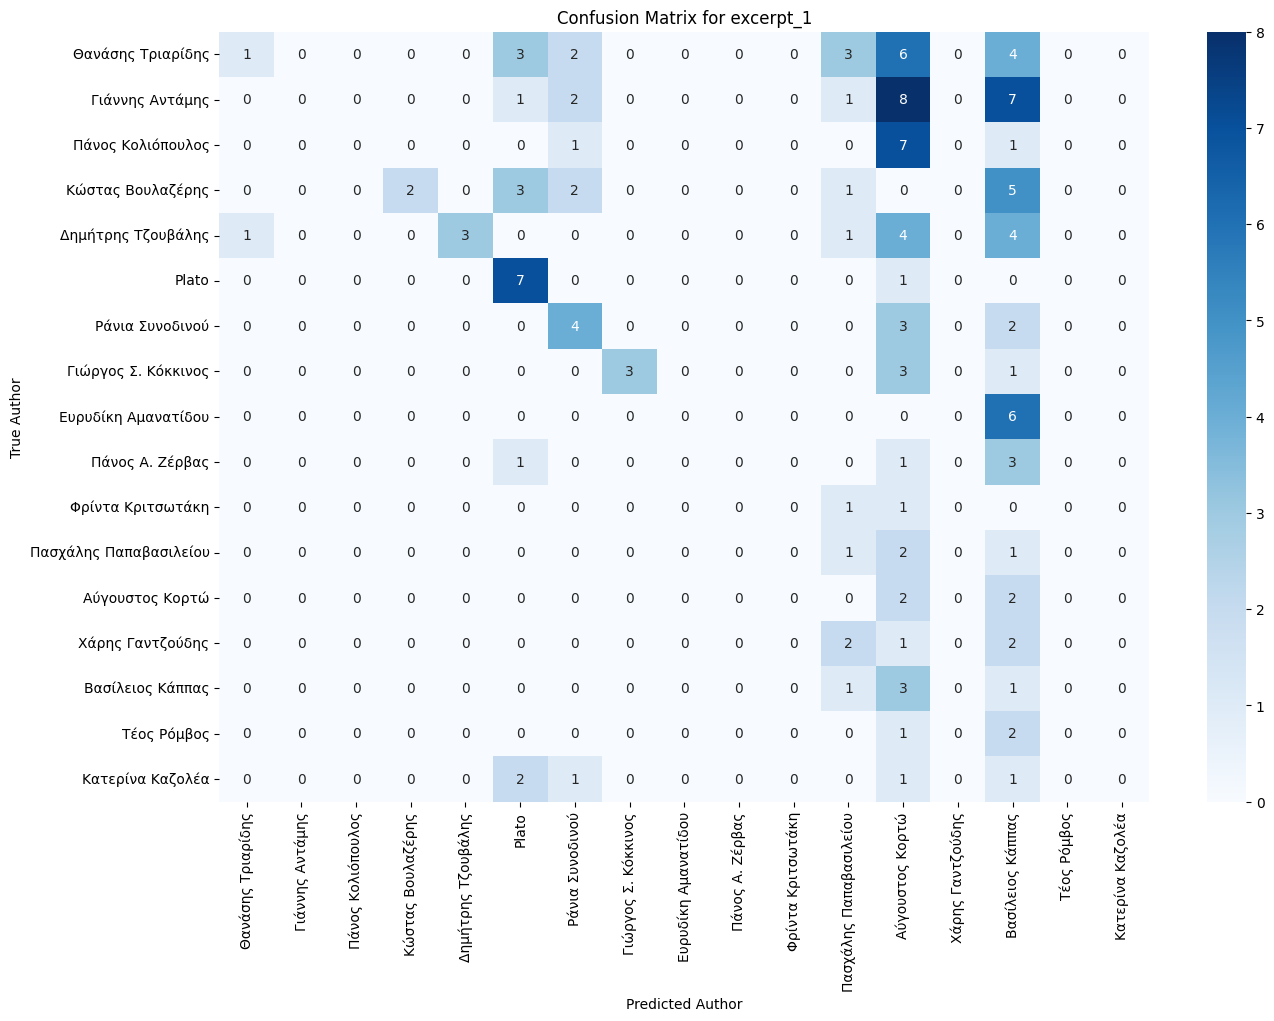

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you want to see the confusion matrix for excerpt_1
y_true = barzokas_pop_mini['author']
y_pred = barzokas_pop_mini['krikri_2'].str.strip()

# Get the unique authors from the dataset to use as labels
labels = pop_authors

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Convert to pandas DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for excerpt_1')
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.show()

https://gemini.google.com/share/62c59af9933f

In [ ]:
# saving
barzokas_pop.to_csv('barzokas_10ex_anonymous_krikri.csv.gz', compression='gzip')